## *Using neural networks to predict and classify crystal structures of elements*

**Why?** Neural networks are widely used for image classification, learning structures and substructures within the data to identify patterns. Such neural network based classifiers can identify patterns and correlations within the data.

**What?** In this tutorial we will learn how to use Neural Networks to create a Classification Model to estimate the ground state of the crystal structure. <br>
This is the third tutorial, following the [MSEML Query_Viz](MSEML_Query_Viz.ipynb), and was based on the classification tutorial in the [TensorFlow Tutorials](https://nanohub.org/tools/tftutorials).

**How to use this?** This tutorial uses Python, some familiarity with programming would be beneficial but is not required. Run each code cell in order by clicking "Shift + Enter". Feel free to modify the code, or change queries to familiarize yourself with the workings on the code.

Suggested modifications and exercises are included in <font color=blue> blue</font>.

**Outline:**

1. Getting a dataset
2. Processing and Organizing Data
3. Creating the Model
4. Plotting


**Get started:** Click "Shift-Enter" on the code cells to run! 

### 1. Getting a dataset

Datasets containing properties for the elements in the periodic table are available online; however, it would be thematic to create our own, using the tools from the first tutorial on [MSEML Query_Viz](MSEML_Query_Viz.ipynb). In this section we will query both [Pymatgen](http://pymatgen.org/) and [Mendeleev](https://mendeleev.readthedocs.io/en/stable/) to get a complete set of properties per element. We will use this data to create the cases from which the model will train and test.
<br>
<br>
In this first snippet of code we will import all relevant libraries, the elements that will be turned into cases and the properties that will serve as the attributes for the cases. We will get 47 entries (which is a small dataset), but should give us a somewhat accurate prediction. It is important to note that more entries would move the prediction closer to the real value, and so would more attributes.
<br>
<br>
The elements listed were chosen because querying them for these properties yields a dataset with no unknown values, and because they represent the three most common crystallographic structures.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential

import pymatgen as pymat
import mendeleev as mendel
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
import sys

fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Ca", "Cr", "Cs", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Rb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Ru", "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn", "Zr"]

elements = fcc_elements + bcc_elements + hcp_elements

random.Random(1).shuffle(elements)

querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point", "en_ghosh",  "evaporation_heat", "heat_of_formation",
                     "lattice_constant", "melting_point", "specific_heat"]
querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity","molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid", "coefficient_of_linear_thermal_expansion"]
querable_values = querable_mendeleev + querable_pymatgen

Using TensorFlow backend.


As before, we will use the database queries to populate lists which can be displayed by the [Pandas](https://pandas.pydata.org/) library in a user-friendly table with the properties as the column headers.

In [2]:
all_values = [] # Values for Attributes
all_labels = [] # Crystal structure labels (0 = fcc, 1 = bcc, 2 = hcp)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item)
    for i in querable_mendeleev:    
        element_values.append(getattr(element_object,i))

    # This section queries Pymatgen
    element_object = pymat.Element(item)    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object,i))
        
    all_values.append(element_values) # All lists are appended to another list, creating a List of Lists
    
    if (item in fcc_elements):
        all_labels.append([1, 0, 0]) # The crystal structure labels are assigned here
    elif (item in bcc_elements):
        all_labels.append([0, 1, 0]) # The crystal structure labels are assigned here
    elif (item in hcp_elements):
        all_labels.append([0, 0, 1]) # The crystal structure labels are assigned here

# Pandas Dataframe
df = pd.DataFrame(all_values, columns=querable_values)

# We will patch some of the values that are not available in the datasets.

# Value for the CTE of Cesium
index_Cs = df.index[df['atomic_number'] == 55]
df.iloc[index_Cs, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000097 
# Value from: David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition. CRC Press. Boca Raton, Florida, 2003

# Value for the CTE of Rubidium
index_Rb = df.index[df['atomic_number'] == 37]
df.iloc[index_Rb, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000090 
# Value from: https://www.azom.com/article.aspx?ArticleID=1834

# Value for the Evaporation Heat of Ruthenium
index_Ru = df.index[df['atomic_number'] == 44]
df.iloc[index_Ru, df.columns.get_loc("evaporation_heat")] = 595 # kJ/mol 
# Value from: https://www.webelements.com/ruthenium/thermochemistry.html

# Value for the Bulk Modulus of Zirconium
index_Zr = df.index[df['atomic_number'] == 40]
df.iloc[index_Zr, df.columns.get_loc("bulk_modulus")] = 94 # GPa 
# Value from: https://materialsproject.org/materials/mp-131/

df.head(n=10)

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,lattice_constant,melting_point,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,youngs_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,27,6.70,3143.0,0.143236,389.1,426.7,2.51,1768.00,0.456,58.933195,1.35,6.000000e-08,6.67,180.0,209.0,0.768333,8900.0,0.000013
1,69,18.10,2220.0,0.216724,232.0,232.2,3.54,1818.00,0.160,168.934210,1.75,6.760000e-07,19.10,45.0,74.0,1.095000,9321.0,0.000013
2,39,19.80,3611.0,0.121699,367.0,424.7,3.65,1795.00,0.284,88.905850,1.80,6.000000e-07,19.88,41.0,64.0,1.040000,4472.0,0.000011
3,75,8.85,5900.0,0.243516,704.0,774.0,2.76,3453.00,0.138,186.207000,1.35,1.800000e-07,8.86,370.0,463.0,0.712500,21020.0,0.000006
4,28,6.60,3005.0,0.147207,378.6,430.1,3.52,1726.00,0.443,58.693400,1.35,7.200000e-08,6.59,180.0,200.0,0.740000,8908.0,0.000013
5,67,18.70,2968.0,0.207795,301.0,300.6,3.58,1747.00,0.164,164.930320,1.75,8.140000e-07,18.74,40.0,65.0,1.041000,8795.0,0.000011
6,79,10.20,3080.0,0.261370,340.0,368.2,4.08,1337.58,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,78.0,1.070000,19300.0,0.000014
7,21,15.00,3104.0,0.119383,332.7,377.8,3.31,1814.00,0.556,44.955912,1.60,5.500000e-07,15.00,57.0,74.0,0.885000,2985.0,0.000010
8,45,8.30,4000.0,0.140838,494.0,556.0,3.80,2239.00,0.244,102.905500,1.35,4.300000e-08,8.28,380.0,275.0,0.745000,12450.0,0.000008
9,74,9.53,5930.0,0.239050,824.0,851.0,3.16,3680.00,0.133,183.840000,1.35,5.400000e-08,9.47,310.0,411.0,0.766667,19250.0,0.000005


### 2. Processing and Organizing Data

We again normalize the data and organize it into training and testing sets as before.

##### SETS

We have 47 elements for which the crystal structure is known and we will use 40 of these as a training set and the remaining 7 as testing set.

##### NORMALIZATION

We will again use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.

<span style="font-size:2em;">$ \frac{X - µ}{σ} $ </span>

While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [3]:
# SETS

all_values = [list(df.iloc[x]) for x in range(len(all_values))]

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float)
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = int)
print("Shape of Labels:", all_labels.shape)

# Training Set
train_values = all_values[:40, :]
train_labels = all_labels[:40, :]

# Testing Set
test_values = all_values[-7:, :]
test_labels = all_labels[-7:, :]

# NORMALIZATION

mean = np.nanmean(train_values, axis = 0) # mean
std = np.nanstd(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

print(train_values[0]) # print a sample entry from the training set
print(train_labels[0])

Shape of Values: (47, 18)
Shape of Labels: (47, 3)
[-0.80084167 -0.75983551 -0.00894162 -0.40732945  0.15599373  0.16654528
 -1.09549525  0.09455406  0.02631292 -0.82400017 -0.80570946 -0.67799461
 -0.75661221  0.70972845  0.6516648  -0.77257498  0.11409173 -0.3075323 ]
[0 0 1]


### 3. Creating the Model

For this classification, we will use a simple sequential neural network with one densely connected hidden layer. The optimizer used will be [RMSPropOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) (Root Mean Square Propagation).

To learn more about Root Mean Squared Propagation, click [here](https://climin.readthedocs.io/en/latest/rmsprop.html).



The key difference between the regression model and the classification model is our metric to measure network performance. While we used mean squared error (between the true outputs and the network's predicted output) for the regression task, we use categorical crossentropy (click [here](https://towardsdatascience.com/demystifying-cross-entropy-e80e3ad54a8) to learn more about it), using classification accuracy as a metric where higher accuracy implies a better network.

# Outline
1. Define a model object
1. add layers to the model
1. model.fit() to train 
1. model.predict() evaluate


In [12]:
# DEFINITION OF THE MODEL

# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=14) #it is the weight

model = Sequential() # Defining a model object in NN it is Sequential() class  from Keras
#input shape defines how many inputs does the neural network have 
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1],), kernel_initializer=kernel_init)) #adding Dense layer 
#model.add(Dense(16, activation='relu', kernel_initializer=kernel_init))
model.add(Dense(3, activation=tf.nn.softmax))  # Output Layer

#In regresssion: MSE and MAE
#softmax conversts the raw out put to probabilities eg: [10, 20, 50] -> [0.2, 0.3, 0.5] #formula \frac {e^{z_i}}{\sum _{j=1}^{K}e^{z_j}}

# DEFINITION OF THE OPTIMIZER

optimizer = tf.train.RMSPropOptimizer(0.002) # Root Mean Squared Propagation

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #accuracy: what fraction of input I am getting correctly # categorical_crossentropy: this is a loss function as we make more and more predictions correctly
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                304       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________


#### TRAINING 

This model is trained for 350 epochs, and we record the training accuracy in the history object. This way, by plotting "history" we can see the evolution of the "learning" of the model, that is the decrease of the Mean Absolute Error. Models in Keras are fitted to the training set using the [**fit**](https://keras.io/models/model/#fit) method.

One **Epoch** occurs when you pass the entire dataset through the model. One **Batch** contains a subset of the dataset that can be fed to the model at the same time. A more detailed explanation of these concepts can be found in this [blog](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9). As we have a really small dataset compared to the ones that are usually considered to be modeled by these neural networks, we are feeding all entries at the same time, so our batch is the entire dataset, and an epoch occurs when the batch is processed.

Instructions for updating:
Use tf.cast instead.


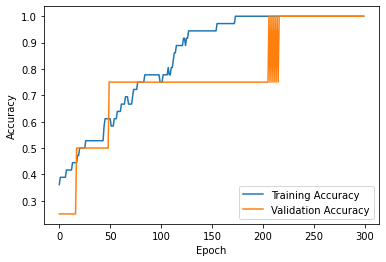

In [5]:
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + '\r') # Updates current Epoch Number


EPOCHS = 300 # Number of EPOCHS

# HISTORY Object which contains how the model learned
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], \
                    epochs=EPOCHS, validation_split=0.1, verbose = False, callbacks=[PrintEpNum()])

# Validation set is a small subset of the traning set to periodicaly check how good or bad is the model is performing

# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy') #instead of loss 
plt.plot(history.epoch, np.array(history.history['acc']),label='Training Accuracy') 
plt.plot(history.epoch, np.array(history.history['val_acc']),label = 'Validation Accuracy')
plt.legend()
plt.show()

#### TESTING

Models in Keras are tested using the method [**evaluate**](https://keras.io/models/model/#evaluate). This method returns the classification accuracy on the training and the testing sets.

In [6]:
loss, acc = model.evaluate(train_values, train_labels, verbose=0) #method evaluate : accuracy

print("Training Set Accuracy: %f" %(acc))

loss, acc = model.evaluate(test_values, test_labels, verbose=0)

print("Testing Set Accuracy: %f" %(acc))

Training Set Accuracy: 1.000000
Testing Set Accuracy: 0.857143


#### MAKING PREDICTIONS

The last step in a Regression Model is to make predictions for values not in the training set, which are determined by the method [**predict**](https://keras.io/models/model/#predict). In the following cell we print the Elements in the testing set, the real values for their Young's Moduli and the predictions generated by the Machine Learning model.

In [7]:
train_predictions = model.predict(train_values)
test_predictions = model.predict(test_values)

all_labels = np.vstack((train_labels, test_labels))
all_predictions = np.vstack((train_predictions, test_predictions))

predicted_labels = []
true_labels = []

#FCC -> [1, 0, 0]
#BCC -> [0, 1, 0]

#[0.6, 0.3, 0.1] -> FCC
#[0.3, 0.36, 0.1] -> BCC


for i in range(all_predictions.shape[0]):
    if (np.argmax(all_predictions[i]) == 0):
        predicted_labels.append("FCC")
    if (np.argmax(all_labels[i]) == 0):
        true_labels.append("FCC")
    if (np.argmax(all_predictions[i]) == 1):
        predicted_labels.append("BCC")
    if (np.argmax(all_labels[i]) == 1):
        true_labels.append("BCC")
    if (np.argmax(all_predictions[i]) == 2):
        predicted_labels.append("HCP")
    if (np.argmax(all_labels[i]) == 2):
        true_labels.append("HCP")

predicted_labels = np.array(predicted_labels).reshape((-1, 1))
true_labels = np.array(true_labels).reshape((-1, 1))
headings = ["Atomic number", "True crystal structure", "Predicted crystal structure"]

atomic_number_array = np.array(df.iloc[:, 0]).reshape((-1, 1))
plot_table = np.concatenate((atomic_number_array, true_labels, predicted_labels), axis=1)

plot_df = pd.DataFrame(plot_table, columns=headings)

In [8]:
plot_df

,Atomic number,True crystal structure,Predicted crystal structure
0,27,HCP,HCP
1,69,HCP,HCP
2,39,HCP,HCP
3,75,HCP,HCP
4,28,FCC,FCC
5,67,HCP,HCP
6,79,FCC,FCC
7,21,HCP,HCP
8,45,FCC,FCC
9,74,BCC,BCC


In [9]:
crystal_structures = ["FCC", "BCC", "HCP"]
FCC_prediction = []
BCC_prediction = []
HCP_prediction = []

for item in range(len(all_predictions)):
    FCC_prediction.append(all_predictions[item].tolist()[0])
    BCC_prediction.append(all_predictions[item].tolist()[1])
    HCP_prediction.append(all_predictions[item].tolist()[2])   

# --------------------------------------------------------------
    
# This block will be used to sort the elements by their atomic number
    
atomic_number = list(df.iloc[:, 0]) # From the Pandas Dataset
order = np.argsort(atomic_number) # Sorting Indexes

# Sorting the lists by the indexes
# elements = [elements[x] for x in order]
# FCC_prediction = [FCC_prediction[x] for x in order]
# BCC_prediction = [BCC_prediction[x] for x in order]
# HCP_prediction =[HCP_prediction[x] for x in order]

# # --------------------------------------------------------------

In [10]:
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

py.offline.init_notebook_mode(connected=True)

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.2)

# ---------
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in fcc_elements], y=[FCC_prediction[_] for _ in range(len(FCC_prediction)) if elements[_] in fcc_elements], name='FCC', marker=dict(color='green'), showlegend=False, textposition='inside', textfont={"size":24},
                        text=['*'  if _ in elements[-7:] else None for _ in [_ for _ in elements if _ in fcc_elements]]), row=1, col=1)

fig.append_trace(go.Bar(x=[_ for _ in elements if _ in fcc_elements], y=[BCC_prediction[_] for _ in range(len(BCC_prediction)) if elements[_] in fcc_elements], name='BCC', marker=dict(color='red'), showlegend=False), row=1, col=1)
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in fcc_elements], y=[HCP_prediction[_] for _ in range(len(HCP_prediction)) if elements[_] in fcc_elements], name='HCP', marker=dict(color='red'), showlegend=False), row=1, col=1) 
# ---------

# ---------

fig.append_trace(go.Bar(x=[_ for _ in elements if _ in bcc_elements], y=[FCC_prediction[_] for _ in range(len(FCC_prediction)) if elements[_] in bcc_elements], name='FCC', marker=dict(color='red'), showlegend=False), row=2, col=1)
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in bcc_elements], y=[BCC_prediction[_] for _ in range(len(BCC_prediction)) if elements[_] in bcc_elements], name='BCC', marker=dict(color='green'), showlegend=False, textposition='outside', textfont={"size":24},
                        text=['*'  if _ in elements[-7:] else None for _ in [_ for _ in elements if _ in bcc_elements]]), row=2, col=1)

fig.append_trace(go.Bar(x=[_ for _ in elements if _ in bcc_elements], y=[HCP_prediction[_] for _ in range(len(HCP_prediction)) if elements[_] in bcc_elements], name='HCP', marker=dict(color='red'), showlegend=False), row=2, col=1)
# ---------

# ---------
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in hcp_elements], y=[FCC_prediction[_] for _ in range(len(FCC_prediction)) if elements[_] in hcp_elements], name='FCC', marker=dict(color='red'), showlegend=False), row=3, col=1)
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in hcp_elements], y=[BCC_prediction[_] for _ in range(len(BCC_prediction)) if elements[_] in hcp_elements], name='BCC', marker=dict(color='red'), showlegend=False), row=3, col=1)
fig.append_trace(go.Bar(x=[_ for _ in elements if _ in hcp_elements], y=[HCP_prediction[_] for _ in range(len(HCP_prediction)) if elements[_] in hcp_elements], name='HCP', marker=dict(color='green'), showlegend=False, textposition='inside', textfont={"size":24},
                        text=['*'  if _ in elements[-7:] else None for _ in [_ for _ in elements if _ in hcp_elements]]), row=3, col=1)
# ---------


fig.update_xaxes(title=go.layout.xaxis.Title(text="FCC Elements", font=dict(size=18)),showgrid=True, tickfont=dict(size=18), row=1, col=1)
fig.update_xaxes(title=go.layout.xaxis.Title(text="BCC Elements", font=dict(size=18)),showgrid=True, tickfont=dict(size=18), row=2, col=1)
fig.update_xaxes(title=go.layout.xaxis.Title(text="HCP Elements", font=dict(size=18)),showgrid=True, tickfont=dict(size=18), row=3, col=1)

fig.update_yaxes(title=go.layout.yaxis.Title(text="Probability", font=dict(size=18)),showgrid=True, tickfont=dict(size=18),range=[0, 1.2], row=1, col=1)
fig.update_yaxes(title=go.layout.yaxis.Title(text="Probability", font=dict(size=18)),showgrid=True, tickfont=dict(size=18),range=[0, 1.2], row=2, col=1)
fig.update_yaxes(title=go.layout.yaxis.Title(text="Probability", font=dict(size=18)),showgrid=True, tickfont=dict(size=18),range=[0, 1.2], row=3, col=1)




fig.update_layout(height=700, width=1200, barmode='group', bargap=0.3)

fig.show()